In [2]:
'''
We will manually compute L1 regularization term ourselves and manually
add it to the loss that Pytorch then uses to train the model.
This helps to leanr about how to access the weights and the biases from 
the model, which gives you more insight into the mechanisms of deep 
learning and Pytorch.
'''

'\nWe will manually compute L1 regularization term ourselves and manually\nadd it to the loss that Pytorch then uses to train the model.\nThis helps to leanr about how to access the weights and the biases from \nthe model, which gives you more insight into the mechanisms of deep \nlearning and Pytorch.\n'

In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# load the dataloader
from torch.utils.data import DataLoader

In [4]:
# import dataset
import seaborn as sns
iris = sns.load_dataset('iris')

In [5]:
# organize the data

# convert from pandas dataframe to tensor
data = torch.tensor(iris[iris.columns[0:4]].values).float()

# transform species into number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa'] = 0 dont' need
labels[iris.species=='versicolor']=1
labels[iris.species=='virginica']=2

In [6]:
# use scikitlearn to split the data
train_data,test_data,train_labels,test_labels = train_test_split(data,labels,test_size=0.1)

# Convert to Pytorch datasets [already converted to tensors]
train_dataDataset = torch.utils.data.TensorDataset(train_data,train_labels)
test_dataDataset = torch.utils.data.TensorDataset(test_data,test_labels)

# create dataloader objects
train_loader = DataLoader(train_dataDataset, batch_size=64, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataDataset, batch_size=64, shuffle=False)

In [8]:
def createANewModel():
    
    # model architecture
    ANNiris = nn.Sequential(
        nn.Linear(4,64),    # input layer
        nn.ReLU(),          # activation unit
        nn.Linear(64,64),   # hidden layer
        nn.ReLU(),          # activation unit
        nn.Linear(64,3)     # output units
    )
    
    # loss function
    lossfun = nn.CrossEntropyLoss()
    
    # optimizer 
    optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.005,)
    
    return ANNiris,lossfun,optimizer

In [10]:
# explore the model in more detail
tmpmodel = createANewModel()[0]

# print the model architecture
print(tmpmodel)

# print the model's parameters
for i in tmpmodel.named_parameters():
    print(i[0],i[1].shape,i[1].numel())

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=3, bias=True)
)
0.weight torch.Size([64, 4]) 256
0.bias torch.Size([64]) 64
2.weight torch.Size([64, 64]) 4096
2.bias torch.Size([64]) 64
4.weight torch.Size([3, 64]) 192
4.bias torch.Size([3]) 3


In [15]:
numepochs = 1000

def trainTheModel(L1lambda):
    
    # initialize accuracies as empties
    trainAcc = []
    testAcc = []
    losses = []
    
    # count the total number of weights in the model.
    nweights = 0
    for pname,weight in ANNiris.named_parameters():
        if 'bias' not in pname:
            nweights = nweights + weight.numel()
    
    # loop over epochs
    for epochi in range(numepochs):
        
        # need to toggle train mode here
        
        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X,y in train_loader:
            
            # forward pass and loss
            yHat = ANNiris(X)
            loss = lossfun(yHat,y)
            
            # add L1 term
            L1_term = torch.tensor(0.,requires_grad=True)
            
            # sum up all abs(weights)
            for pname,weight in ANNiris.named_parameters():
                if 'bias' not in pname:
                    L1_term = L1_term + torch.sum(torch.abs(weight))
            # add to loss term
            loss = loss + L1lambda * L1_term/nweights
            
            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # compute training accuracy just for this batch
            batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()).item())
            batchLoss.append(loss.item())
        # end of batch loop
        
        # now that we have trained through the batches,get their average 
        #training accuracy
        
        trainAcc.append(np.mean(batchAcc))
        losses.append(np.mean(batchLoss))

        
        # test accuracy
        ANNiris.eval()
        X,y = next(iter(test_loader))  # extract X,y from test dataloader
        predlabels = torch.argmax(ANNiris(X),axis=1)
        testAcc.append(100*torch.mean((predlabels==y).float()).item())
        
        # no worries, reset here :)
        ANNiris.train()
        
    # function output
    return trainAcc,testAcc,losses
            

In [18]:
# create a model
ANNiris,lossfun,optimizer = createANewModel()

# train the model
L1lambda = .001
trainAcc, testAcc, losses = trainTheModel(L1lambda)

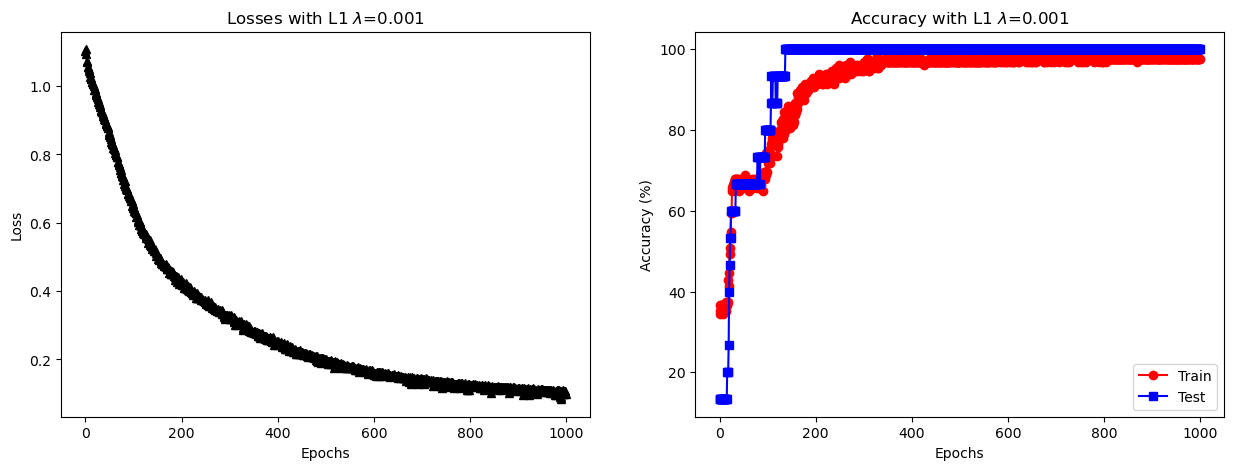

In [21]:
# plot the results

fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(losses,'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with L1 $\lambda$=' + str(L1lambda))

ax[1].plot(trainAcc,'ro-')
ax[1].plot(testAcc,'bs-')
ax[1].set_title('Accuracy with L1 $\lambda$='+ str(L1lambda))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])

plt.show()


In [22]:
# create a 1D smoothing filter
def smooth(x,k):
    return np.convolve(x,np.ones(k)/k, mode='same')

In [26]:
# range of L1 regularization amounts
L1lambda = np.linspace(0,.005,10)

# initialize output eresults matrices
accuracyResultsTrain = np.zeros((numepochs,len(L1lambda)))
accuracyResultsTest = np.zeros((numepochs, len(L1lambda)))

# loop over batch sizes
for li in range (len(L1lambda)):
    
    # create and train the model
    ANNiris,lossfun,optimizer = createANewModel()
    trainAcc,testAcc,losses = trainTheModel(L1lambda[li])
    
    # store data
    accuracyResultsTrain[:,li] = smooth(trainAcc,10)
    accuracyResultsTest[:,li] = smooth(testAcc,10)

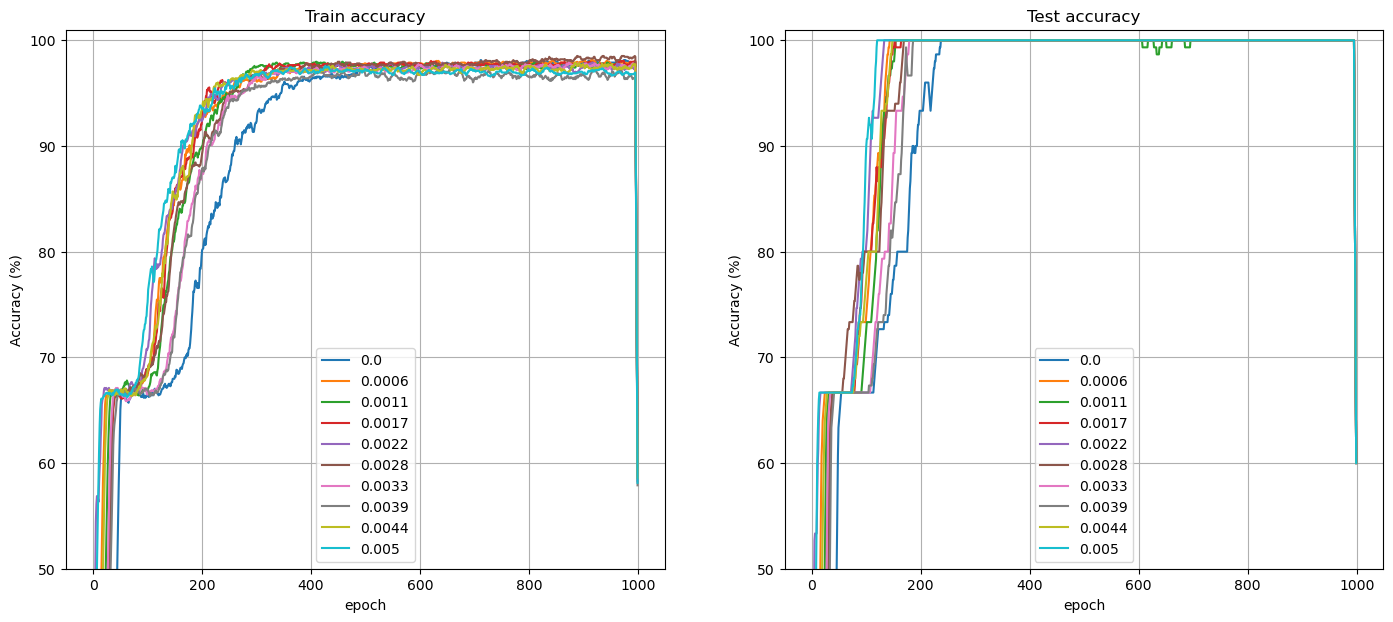

In [33]:
# plot some results

fig,ax = plt.subplots(1,2,figsize=(17,7))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test accuracy')

# make the legend easier to read
leglabels = [np.round(i,4) for i in L1lambda]

# common features
for i in range(2):
    ax[i].legend(leglabels)
    ax[i].set_xlabel('epoch')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([50,101])
    ax[i].grid()
    
plt.show()

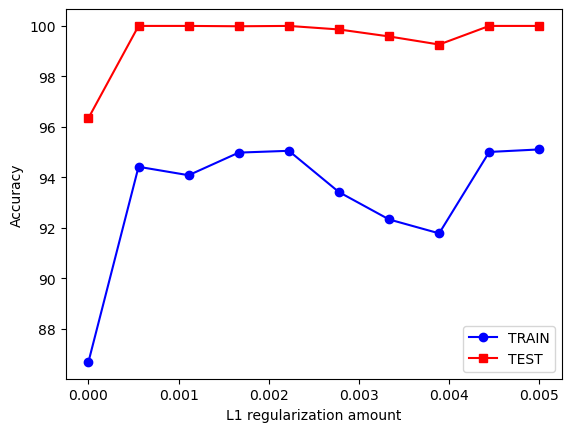

In [37]:
# show average accuracy by L2 rate

# average only some epochs
epoch_range = [160,360]

plt.plot(L1lambda, np.mean(accuracyResultsTrain[epoch_range[0]:epoch_range[1],:],axis=0),'bo-',label='TRAIN')
plt.plot(L1lambda,np.mean(accuracyResultsTest[epoch_range[0]:epoch_range[1],:],axis=0),'rs-',label='TEST')
plt.xlabel('L1 regularization amount')
plt.ylabel('Accuracy')
plt.legend()
plt.show()